In [11]:
base_path = '/tf/PatchCL-MedSeg-jiyu'
import sys
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import math
import time
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
sys.path.append(base_path)

from utils.transform import Transform
from utils.stochastic_approx import StochasticApprox
from utils.model import Network
from utils.datasets import LabData,UnlabData
from utils.queues import Embedding_Queues
from utils.CELOSS import CE_loss
from utils.patch_utils import _get_patches
from utils.aug_utils import batch_augment
from utils.get_embds import get_embeddings
from utils.const_reg import consistency_cost
from utils.plg_loss import PCGJCL
from utils.torch_poly_lr_decay import PolynomialLRDecay

In [2]:
dev=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
embd_queues = Embedding_Queues(4)
stochastic_approx = StochasticApprox(4,0.5,0.8)
contrastive_batch_size = 128
img_size = 256
batch_size = 8
num_classes = 4
transform = Transform(img_size, num_classes)

In [4]:
model = Network()
teacher_model = Network()

#Turning off gradients for teacher model
for param in teacher_model.parameters():
    param.requires_grad=False
    #Esuring mothe the models have same weight
teacher_model.load_state_dict(model.state_dict())
model.contrast=False
teacher_model.contrast = False

model = nn.DataParallel(model)
model = model.to(dev)
teacher_model = nn.DataParallel(teacher_model)
teacher_model=teacher_model.to(dev)

KeyboardInterrupt: 

In [5]:
cross_entropy_loss=CE_loss()
metrics=[smp.utils.metrics.IoU(threshold=0.5)]

optimizer_pretrain=torch.optim.Adam(model.parameters(),lr=0.001)
optimizer_ssl=torch.optim.SGD(model.parameters(),lr=0.007)
scheduler = PolynomialLRDecay(optimizer=optimizer_pretrain, max_decay_steps=200, end_learning_rate=0.0001, power=2.0)

TypeError: __init__() missing 2 required positional arguments: 'num_classes' and 'image_size'

total 1312 samples
total 1312 samples
number of labeled_dataset:  1312
number of unlabeled_dataset:  164
image shape:  torch.Size([8, 3, 256, 256])
masks shape:  torch.Size([8, 4, 256, 256])
class 0 mask_pixel_counts:  {0.0: 2963, 1.0: 62573}
class 1 mask_pixel_counts:  {0.0: 63897, 1.0: 1639}
class 2 mask_pixel_counts:  {0.0: 64913, 1.0: 623}
class 3 mask_pixel_counts:  {0.0: 64835, 1.0: 701}


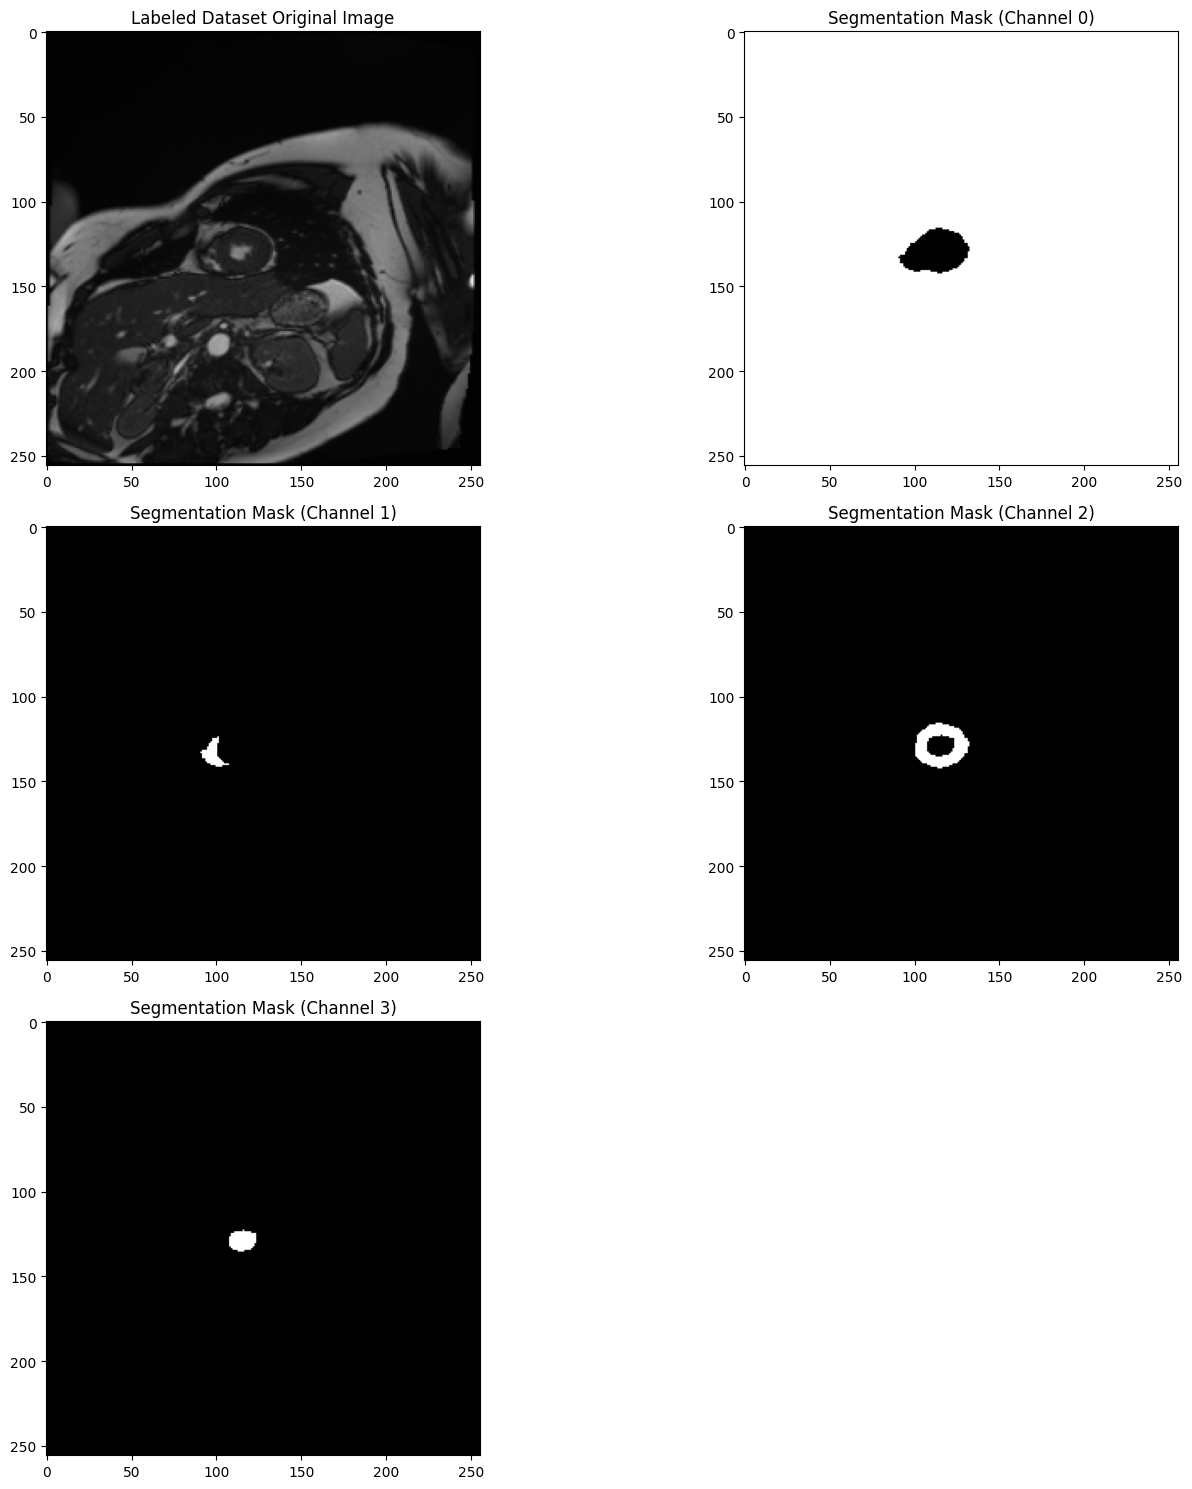

image shape:  torch.Size([8, 3, 256, 256])


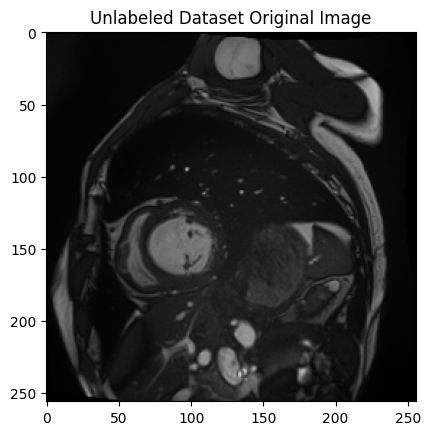

In [16]:
labeled_dataset = LabData(base_dir='/tf/PatchCL-MedSeg-jiyu/ACDC', split='train', transform=transform)
unlabeled_dataset = UnlabData(base_dir='/tf/PatchCL-MedSeg-jiyu/ACDC', split='train', transform=transform)
labelled_dataloader = DataLoader(labeled_dataset,batch_size=batch_size,shuffle=True)
unlabeled_dataloader = DataLoader(unlabeled_dataset,batch_size=batch_size,shuffle=True)


print('number of labeled_dataset: ', len(labeled_dataset))
print('number of unlabeled_dataset: ', len(unlabeled_dataloader))
print('=====================================')
for batch in labelled_dataloader:
    imgs = batch['image']
    masks = batch['label']
    break

print('image shape: ', imgs.shape)
print('masks shape: ', masks.shape)

# 每個 channel pixel 內容
for i in range(num_classes):
    mask_unique, mask_counts = np.unique(masks[1][i], return_counts=True)
    mask_pixel_counts = dict(zip(mask_unique, mask_counts))
    print(f'class {i} mask_pixel_counts: ', mask_pixel_counts)
    
    
plt.figure(figsize=(15, 15))
# 左邊顯示原圖
plt.subplot(3, 2, 1)
plt.imshow(imgs[0].permute(1, 2, 0))
plt.title("Labeled Dataset Original Image")

# 顯示各個通道的分割掩碼
plt.subplot(3, 2, 2)
plt.imshow(masks[0][0], cmap='gray')
plt.title("Segmentation Mask (Channel 0)")

plt.subplot(3, 2, 3)
plt.imshow(masks[0][1], cmap='gray')
plt.title("Segmentation Mask (Channel 1)")

plt.subplot(3, 2, 4)
plt.imshow(masks[0][2], cmap='gray')
plt.title("Segmentation Mask (Channel 2)")

plt.subplot(3, 2, 5)
plt.imshow(masks[0][3], cmap='gray')
plt.title("Segmentation Mask (Channel 3)")

plt.tight_layout()
plt.show()

print('=====================================')
for batch in unlabeled_dataloader:
    imgs = batch['image']
    break
print('image shape: ', imgs.shape)
# 左邊顯示原圖
plt.imshow(imgs[0].permute(1, 2, 0))
plt.title("Unlabeled Dataset Original Image")
plt.show()